# Objectif 

Réaliser un projet de data science de bout en bout à partir de données de cas d’usage réel. L’objectif sera alors d’appliquer un algorithme d’apprentissage automatique et/ou de réseau neuronal sur un ensemble de données réelles.

## `Détection de fuite`

Pour un opérateur public de distribution d’eau, la détection rapide des fuites sur le réseau est un enjeu stratégique majeur. 
Les équipes terrain interviennent quotidiennement sur des milliers de kilomètres de canalisation, où les fuites peuvent passer inaperçues et entraîner des pertes  importantes d’eau, des coûts élevés et des  perturbations du service.

HUPI travaille depuis plusieurs mois afin de développer un Assistant Virtuel de détection de fuites, basé sur des modèles de Machine Learning. 
Cet assistant prend en compte :
- les caractéristiques du réseau, 
- les données historiques de consommation et de pression, 
- ainsi que le profil et les habitudes de fonctionnement du réseau, afin d’alerter automatiquement et judicieusement lorsqu’un risque de fuite est détecté.

L’objectif est de concevoir des modèles auto-apprenants, capables de s’adapter aux spécificités de chaque zone géographique et de chaque type d’infrastructure, afin de générer des alertes personnalisées et adaptées à chaque contexte de réseau.

Vous disposez d’un ensemble de données contenant les mesures quotidiennes de consommation d’eau pour 502 compteurs différents. Chaque ligne correspond à une observation d’un compteur à une date donnée.

Les variables sont les suivantes :
    
    - valeur_active : consommation mesurée (en m³)
    - valeur_date : date de la mesure (quotidienne)
    - libelle : identifiant du compteur (502 valeurs différentes)


L’objectif du projet est d’analyser et de caractériser la consommation d’eau des différents compteurs. Pour répondre à cette problématique, trois tâches principales peuvent être menées :
- Prédire la consommation future des compteurs à partir de leurs historiques.
- Identifier la tendance de la consommation (hausse, stabilité, baisse).
- Classer les niveaux de consommation (faible, moyen, fort) pour caractériser les comportements des compteurs.

# Chargement

## Bibliothèques

source ~/python_envs/projet_hupi/bin/activate

In [254]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import STL
from scipy.signal import periodogram
from scipy.optimize import curve_fit
import math
import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Fonctions utiles

In [ ]:
def impression(data, libelles=[], colonnes=[]):

    """
    Imprime les séries de data par libelle
    Arguments :
    - libelles (list) : libellés à imprimer. Par défaut, imprime tous les libellés de data
    - colonne (list) : colonnes de data à imprimer. Par défaut, imprime valeur_active
    """
    if len(libelles)==0:
        libelles = list(np.random.choice(
        data["libelle"].unique(),
        size=10,
        replace=False,
        ))

    if len(colonnes)==0:
        colonnes='valeur_active'

    n = len(libelles)

    if n==0:
        pass
    
    n_cols = 3
    n_rows = math.ceil(n / n_cols)  # nombre de lignes nécessaires
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()  # aplatir pour itérer facilement    

    for i, libelle in enumerate(libelles):
        mask=data["libelle"] == libelle
        df = data[mask].sort_values("date").set_index('date')
        axes[i].plot(df[colonnes])
        axes[i].set_title(libelle)         
        axes[i].tick_params(axis='x',labelrotation=45)

    # Supprimer les axes vides si n < n_rows*n_cols
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

## Données

In [256]:
#%python_ecole
file_path = "./data/"
project_name_eau = "detection_fuite.csv"

print("*** Chargement des données *** \n")
data_eau = pd.read_csv(f"{file_path}/{project_name_eau}")
print(f"Affichage des premières lignes du dataset : \n\n {data_eau.head()} \n\n")
print(f"Dimension du dataset : {data_eau.shape}")

*** Chargement des données *** 

Affichage des premières lignes du dataset : 

    valeur_active valeur_date libelle
0           35.0  2019-01-01    ID_1
1            0.0  2019-01-01    ID_2
2            2.0  2019-01-01    ID_3
3           38.0  2019-01-01    ID_4
4           38.0  2019-01-01    ID_5 


Dimension du dataset : (470900, 3)


In [257]:
# conversion date et tri
data_eau["date"] = pd.to_datetime(data_eau["valeur_date"])
data_eau=data_eau.sort_values(['libelle','date'])

# Exploration globale des données

## analyse de la valeur_active

In [258]:
data_eau.describe()

,valeur_active,date
count,4.488080e+05,470900
mean,1.160575e+03,2023-05-31 01:21:35.755361536
min,-8.740000e+01,2019-01-01 00:00:00
25%,7.972603e-01,2022-09-20 00:00:00
50%,5.100000e+00,2023-07-16 00:00:00
75%,2.000000e+01,2024-04-16 00:00:00
max,9.999999e+07,2024-12-31 00:00:00
std,3.013335e+05,NaN


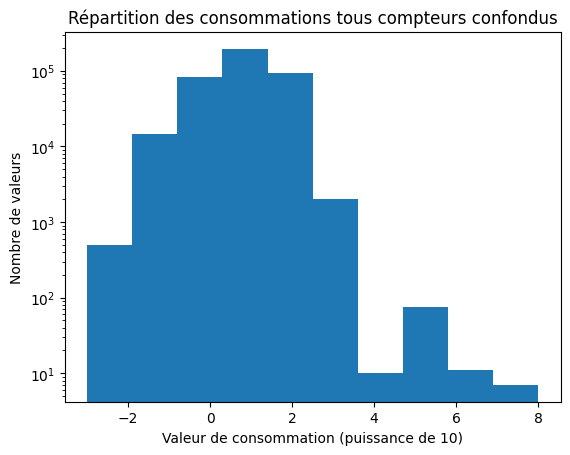

In [259]:
plt.hist(np.log10(data_eau[data_eau['valeur_active']>0]['valeur_active']))
plt.title('Répartition des consommations tous compteurs confondus')
plt.ylabel('Nombre de valeurs')
plt.xlabel('Valeur de consommation (puissance de 10)')
plt.yscale('log')


Il y a des valeurs négatives et quelques valeurs extremes à retirer

## nettoyage

Convertir la colonne valeur_date en type datetime qui sera plus facile à manipuler avec pandas et retirer les valeurs nan ou négatives

In [260]:
# retirer valeur négatives
data_eau[data_eau['valeur_active']<0]=np.nan

# retirer les valeurs extrèmes
data_eau[data_eau['valeur_active']>1e3]=np.nan

# retirer nan
data_eau = data_eau[data_eau["valeur_active"].notna()].copy()
data_eau.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448588 entries, 0 to 470760
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   valeur_active  448588 non-null  float64       
 1   valeur_date    448588 non-null  object        
 2   libelle        448588 non-null  object        
 3   date           448588 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 17.1+ MB


In [261]:
data_eau.describe()

,valeur_active,date
count,448588.000000,448588
mean,22.258220,2023-06-07 01:21:26.950163712
min,0.000000,2019-01-01 00:00:00
25%,0.798434,2022-09-25 00:00:00
50%,5.100000,2023-07-28 00:00:00
75%,20.000000,2024-04-22 00:00:00
max,992.400024,2024-12-31 00:00:00
std,53.865953,NaN


## Analyse du nombre de compteur actif

In [262]:
data_metrics = (
    data_eau
      .groupby(data_eau['date'].dt.to_period('D'))
      .agg(
          nb_unique_libelle=("libelle", "nunique"),
          nb_valeur_active=("valeur_active", "count"),
          min_valeur_active=("valeur_active", "min"),
          max_valeur_active=("valeur_active", "max"),
          moy_valeur_active=("valeur_active", "mean"),
      )
)

In [263]:
data_metrics.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2192 entries, 2019-01-01 to 2024-12-31
Freq: D
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nb_unique_libelle  2192 non-null   int64  
 1   nb_valeur_active   2192 non-null   int64  
 2   min_valeur_active  2192 non-null   float64
 3   max_valeur_active  2192 non-null   float64
 4   moy_valeur_active  2192 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 102.8 KB


<Axes: xlabel='date'>

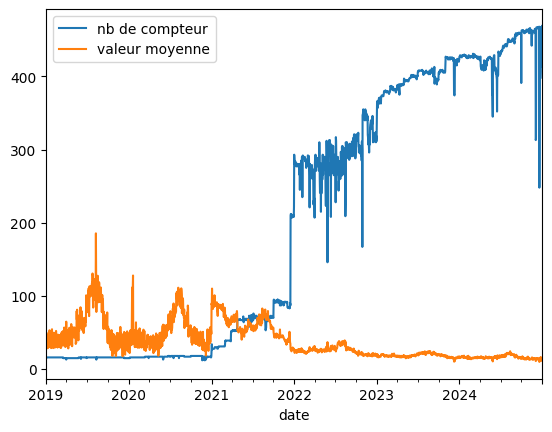

In [264]:
data_metrics['nb_unique_libelle'].plot(label="nb de compteur", legend=True)
data_metrics['moy_valeur_active'].plot(label="valeur moyenne", legend=True)


Il existe quatre périodes :
- 2019-2020 : 20 compteurs
- 2021 : ajout progressif d'une centaine de compteurs
- 2022 : ajout de 200 compteurs avec beaucoup de valeurs manquantes
- 2023-2024 : stabilisation des valeurs et ajout progressif jusqu'à un total de 450 compteurs

# Exploration des compteurs

## Sélection des dates

On explore sur la période 2022-24 qui est celle avec le plus de compteurs

In [265]:
start_date = "2022-01-01"
data=data_eau[(data_eau["date"]>=start_date)][['libelle','date','valeur_active']].copy()

In [266]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 490


## Pré-visualisation des données

Afficher quelques courbes

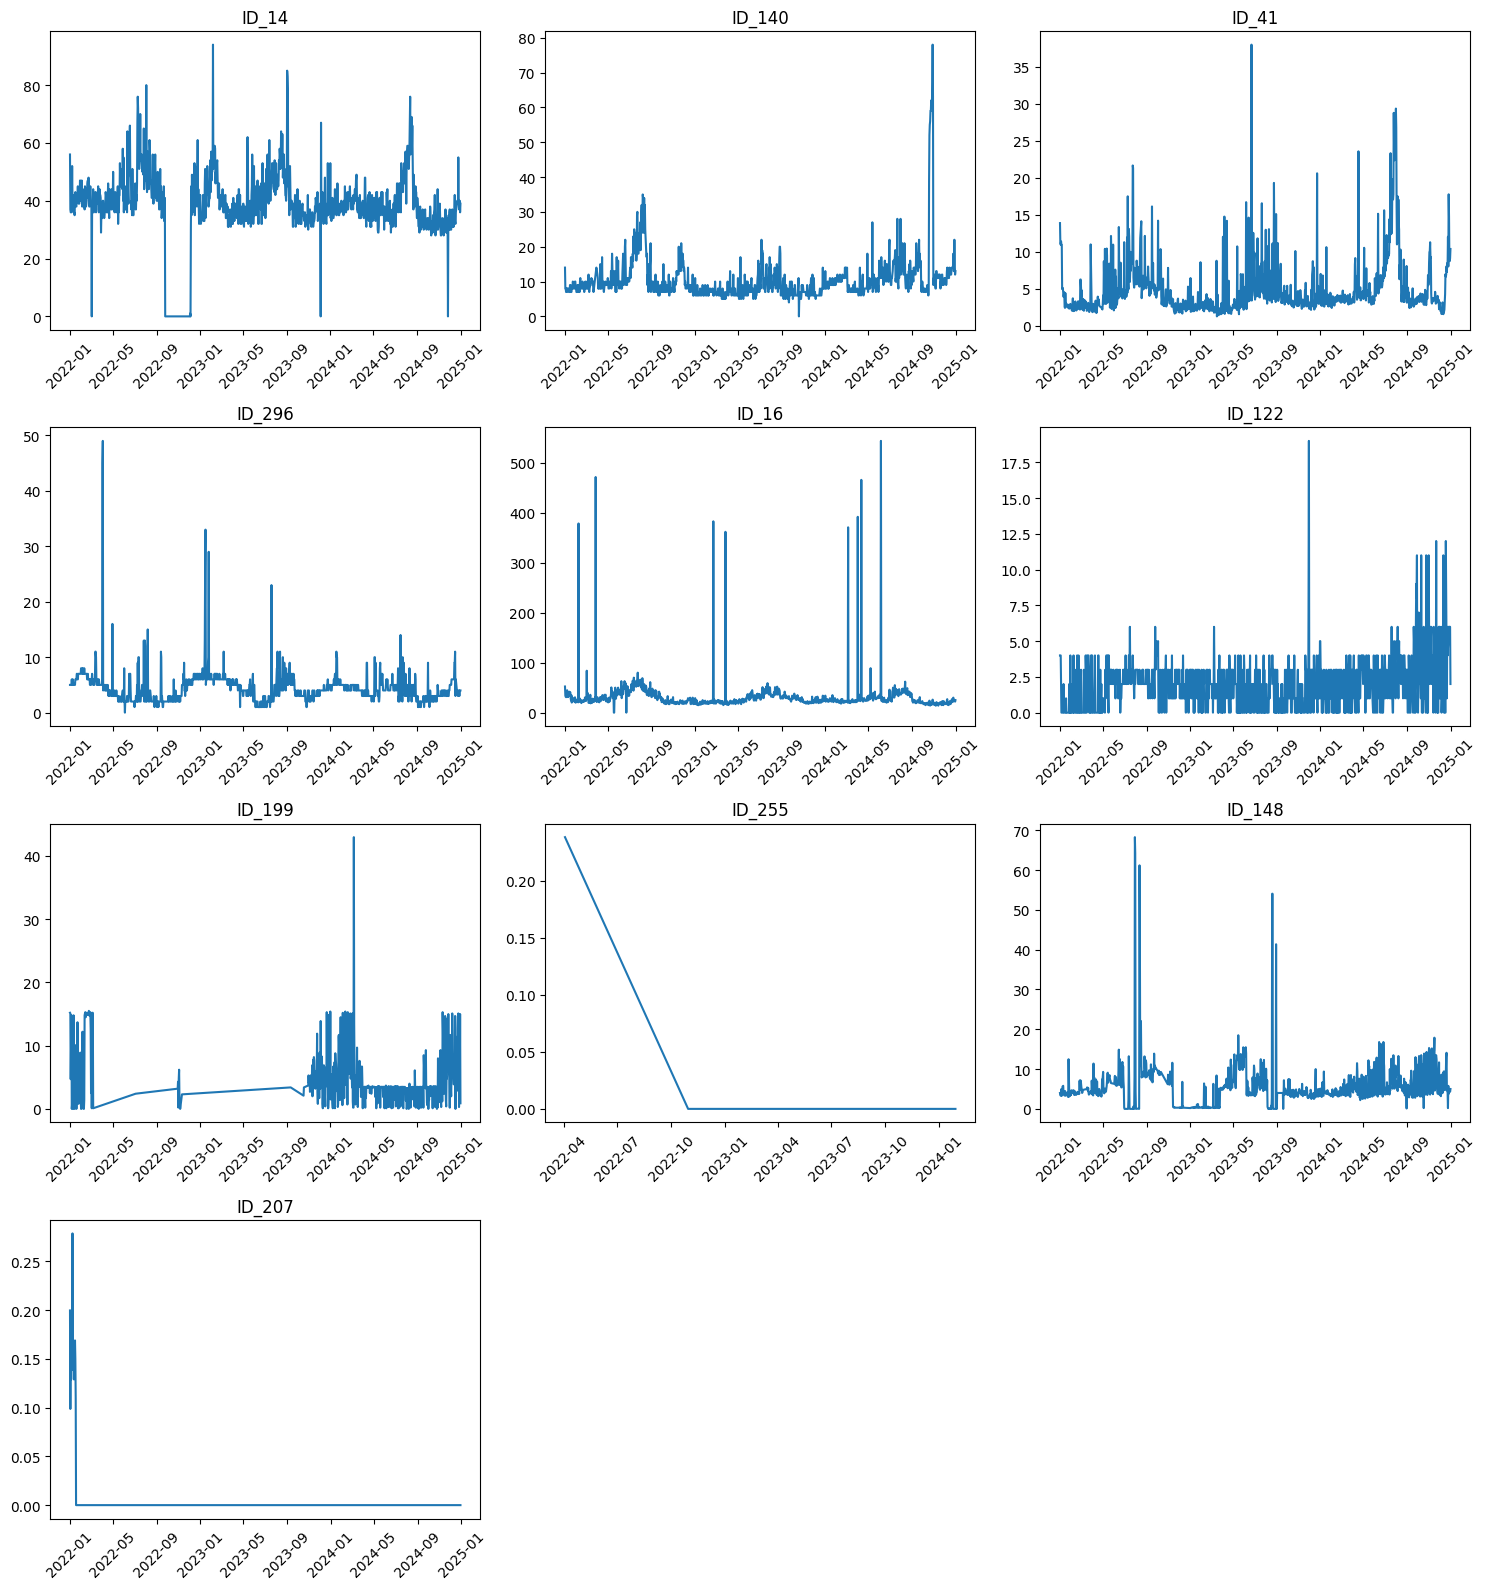

In [267]:
impression(data)

L'observation des compteurs montrent :
- valeurs manquantes
- valeurs nulles ou quasi-nulles
- valeurs pics (valeur significativement élecvée pendant une période très courte)

L'observation montre aussi des fluctuations quotidiennes importantes et ce qu'il semble être une saisonnalité annuelle pour certains compteurs.

L'enjeux va dont être de nettoyer puis d'extraire des données les saisonnalités et la tendance pour ne conserver que le bruit résiduels et y identifier des anomalies en tant que fuite. 

## Nettoyage

In [268]:
# retirer valeur nulles
data.loc[data['valeur_active']==0, 'valeur_active'] = np.nan

In [269]:
# retirer valeur quasi-nulles et pic
q01 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.01))
)

q99 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.99))
)


data.loc[(data['valeur_active'] <= q01) | (data['valeur_active'] >= q99), 'valeur_active'] = np.nan
data = data[data["valeur_active"].notna()].copy()

In [270]:

# retirer les compteurs avec moins de 80% de données
nbre_valeur_par_compteur=(data
    .groupby('libelle')['valeur_active']
    .count())

In [271]:
nbre_valeur_par_compteur.describe()

count     476.000000
mean      703.611345
std       338.159573
min         1.000000
25%       454.000000
50%       806.500000
75%      1007.000000
max      1098.000000
Name: valeur_active, dtype: float64

Text(0.5, 0, 'Nombre de valeurs du compteur')

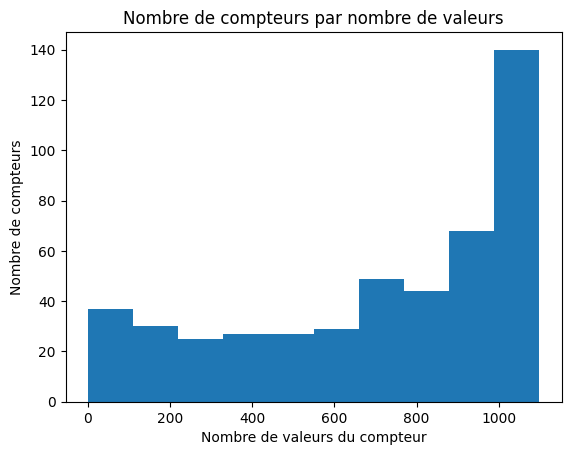

In [272]:
plt.hist(nbre_valeur_par_compteur)
plt.title('Nombre de compteurs par nombre de valeurs')
plt.ylabel('Nombre de compteurs')
plt.xlabel('Nombre de valeurs du compteur')

In [273]:
seuil = 0.8 * nbre_valeur_par_compteur.max()
libelles_volumineux = nbre_valeur_par_compteur[nbre_valeur_par_compteur > seuil].index
data=data[data['libelle'].isin(libelles_volumineux)].copy()

In [274]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 208


## Clusterisation

le client a préciser qu'il existait deux catégories de compteurs selon le débit. Nous allons séparer les compteurs en cluster et conserver le cluster principal.

In [275]:
moyenne_par_compteur=data.groupby('libelle')['valeur_active'].mean().reset_index()
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(moyenne_par_compteur[['valeur_active']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
moyenne_par_compteur["cluster"] = labels

In [276]:
moyenne_par_compteur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   libelle        208 non-null    object 
 1   valeur_active  208 non-null    float64
 2   cluster        208 non-null    int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 4.2+ KB


In [277]:
moyenne_par_compteur.groupby('cluster')['valeur_active'].agg(['count','max', 'mean'])

,count,max,mean
cluster,,,
0,183,70.762334,14.266742
1,25,389.861712,132.359314


Text(0.5, 9.444444444444438, 'Moyenne de consommation du compteur')

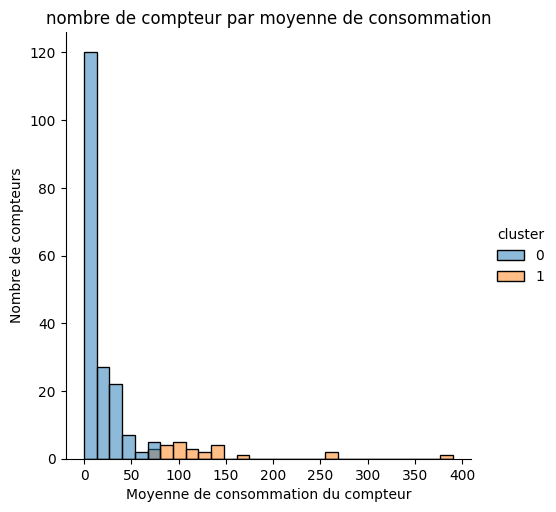

In [278]:
sns.displot(data=moyenne_par_compteur, x="valeur_active", hue="cluster")
plt.title('nombre de compteur par moyenne de consommation')
plt.ylabel('Nombre de compteurs')
plt.xlabel('Moyenne de consommation du compteur')

In [279]:
cluster_principal = moyenne_par_compteur['cluster'].value_counts().idxmax()
libelles_principaux = moyenne_par_compteur[moyenne_par_compteur['cluster'] == cluster_principal]['libelle']
data=data[data['libelle'].isin(libelles_principaux)].copy()

In [280]:
print(f"nombre de compteurs : {len(data['libelle'].unique())}")

nombre de compteurs : 183


## Resampling

Pour l'analyse de la saisonnalité, un resampling est nécessaire afin de rendre les suites temporelles continues

In [281]:
def resample_and_interpolate(group):
    # Trier par date
    group = group.sort_values('date').set_index('date')
    
    # Resample quotidien uniquement avec moyenne pour doublon
    group_num = group[['valeur_active']].resample('D').mean()
    
    # Interpolation time
    group_num['valeur_active'] = group_num['valeur_active'].interpolate(method='time')
    
    # Remettre libelle
    group_num['libelle'] = group['libelle'].iloc[0]
    
    return group_num

# Appliquer par libelle
#group_keys=False pour que le libelle ne soit pas ajouté comme index supplémentaire
#reset index pour mettre les dates resamplée en colonnes
data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


/tmp/ipykernel_5516/1685603811.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


# Analyse de la saisonnalité

Une fuite peut être considérée comme un changement de tendance à moyen terme (sur quelques semaines) qui n'est pas liée à une saisonnalité. Afin de les isoler, il convient donc d'éliminer des données les saisonnalités et les tendances de long terme (sur plusieurs mois). Il est donc nécessaire de déterminer au préalable les saisonnalités présentes.

## Metrics de saisonnalité

Pour déterminer les périodes de saisonnalité, l'analyse par **Transformée de Fourrier Rapide (FFT)** se révèle très efficace en déterminant le poids dans la variance de fréquence avec un temps de calcul très court contrairement à la STL. Cependant, elle fonctionne correctement pour des fréquences de période inférieures au tiers de la longueur de la série temporelle. Nos séries couvrant 3 années, elles sont suffisamment longues pour identifier les saisonnalité sub-annuelle mais non des saisonnalités annuelles ou super-annuelles.

Pour l'anayse du poids des saisonnalités, nous utilisons le **Seasonal Variance Ratio (SVR)** issu du SNR en traitement de signal.

**Signal-to-Noise Ratio (SNR)** analyse le bruit résiduel dans un signal :
```math
SNR=\frac{Puissance_{signalUtile}}{Puissance_{noise}}
```
La puissance est la moyenne du carré d'un signal centré sur zéro, soit sa variance.

Dans un signal avec des composantes décorrélées, les variances s'additionnent : $Var_{signal}=Var_{season}+Var_{trend}+Var_{noise}$\

Pour le SNR, Signal Util = Season + Trend.

Le SVR est défini ainsi comme la part de la puissance totale issue de la saisonnalité :
```math
SVR=\frac{Var_{seasonalité}}{Var_{totale}}
```

Le seuil significatif statistique est de 10%.

Pour une période de saisonnalité observée, le SVR est estimé en projetant l’ensemble des observations sur leur phase intra-période, en agrégeant les valeurs par bins de phase sur tous les cycles disponibles, et en calculant la variance des bins rapportée à la variance du signal.

Le nombre de bins contrôle la résolution intra-période. c'est un compromis biais/variance :
- peu de bins = profil très lissé
- beaucoup de bins = profil détaillé mais bruité

Source :
- [STL](https://en.wikipedia.org/wiki/Decomposition_of_time_series)
- [FFT](https://fr.wikipedia.org/wiki/Transformation_de_Fourier_rapide)
- [puissance d'un signal](https://fr.wikipedia.org/wiki/%C3%89nergie_d%27un_signal)
- [saisonnalité](https://en.wikipedia.org/wiki/Seasonality)
- [puissance d'un signal](https://fr.wikipedia.org/wiki/%C3%89nergie_d%27un_signal)
- [SNR](https://fr.wikipedia.org/wiki/Rapport_signal_sur_bruit)

In [282]:
def seasonal_cv_binned_full(group, period, n_bins=12):
    """
    Calcule un CV saisonnier en découpant d'abord la série en bins intra-période,
    puis en agrégeant toutes les observations (fenêtres complètes ou non).

    Arguments
    ----------
    series : pd.Series
        Série temporelle (index quelconque, valeurs numériques)
    period : int
        Période cible (ex : 365, 30, 7)
    n_bins : int
        Nombre de bins intra-période (par défaut 12 à l'instar des 12 mois d'une saisonnalité annuelle)

    Retourne
    -------
    float
        Coefficient de variation saisonnier
    """

    # Transformation en série temporelle
    group = group.sort_values('date').set_index('date')
    
    # Trier par date
    group = group.sort_index()

    # Nettoyage
    values = group['valeur_active'].dropna()
    N = len(values)

    # Sécurité : pas assez de données pour une saisonnalité
    if N < period:
        return np.nan

    # Position intra-période (0 → period-1)
    positions = np.arange(N) % period

    # Bins intra-période
    bin_edges = np.linspace(0, period, n_bins + 1)

    # Attribution des bins
    bin_ids = np.digitize(positions, bin_edges, right=False) - 1 #prend chaque valeur de positions et retourne l'indice de bin auquel elle appartient
    
    # Sécurité : borne bin_ids a [0,n_bins - 1] (a priori impossible d'être en dehors avec right=False mais au cas où ...)
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    # Agrégation
    bin_means = values.groupby(bin_ids).mean()

    # Sécurité : bins vides (rare mais possible)
    bin_means = bin_means[~np.isnan(bin_means)]

    # Sécurité : pas assez de bins pour un calcul de variance (a priori impossible sauf a choisir n_bins=1)
    if len(bin_means) < 2:
        return np.nan

    # CV
    # mean_level = bin_means.mean()

    # if np.isclose(mean_level, 0):
    #     return bin_means.std() / values.std()

    return bin_means.var() / values.var()


In [283]:
svr_series = data_resampled.groupby('libelle')[['valeur_active', 'date']].apply(lambda g: pd.Series({
    'svr_annual': seasonal_cv_binned_full(g, 365),
    'svr_semestrial': seasonal_cv_binned_full(g, 180),
    'svr_trimestrial': seasonal_cv_binned_full(g, 90),
    'svr_monthly': seasonal_cv_binned_full(g, 30),
}))

## Recherche de la saisonnalité annuelle

Le calcul du SVR confirma la présence significative de saisonnalité annuelle sur une majorité de compteurs.

Cela implique que le STL ne pourra pas être utilisé. En effet, il nécessite au moins 5 périodes et la dernière période n'est pas décomposée. Or dans notre cas, avec une période de 365 jours, les séries couvre seulement 3 périodes et nous avons besoin de déterminer la présence de fuite sur la dernière période précisément. 

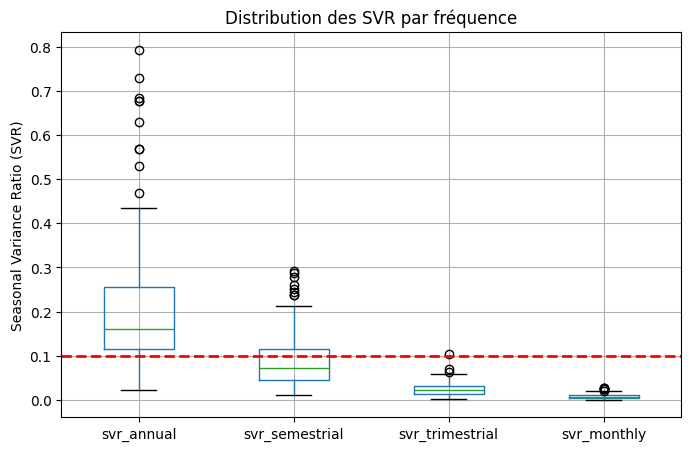

In [284]:
plt.figure(figsize=(8, 5))
svr_series[['svr_annual', 'svr_semestrial','svr_trimestrial', 'svr_monthly']].boxplot()
plt.ylabel("Seasonal Variance Ratio (SVR)")
plt.title("Distribution des SVR par fréquence")
plt.axhline(y=0.1, color='red', linestyle='--', linewidth=2)
plt.show()

## Recherche des saisonnalités sub-annuelles

L'analyse par FFT fournit la puissance des fréquences anaylsée. La puissance est une densité de variance, c'est donc le SVR de la fréquence.

In [285]:
def spectral_dataframe(serie, fs=1):
    """
    Calcule le périodogramme et retourne un DataFrame (freq, period, power)

    Arguments
    ----------
    series : pd.Series
        Série temporelle (index datetime ou range)
    fs : float
        Fréquence d'échantillonnage (1 = journalier)

    Retourne
    -------
    pd.DataFrame
    """
    # Drop NaN
    y = serie.dropna().values

    # Retirer la moyenne (dé-trend simple)
    y = y - np.mean(y)

    freqs, power = periodogram(y, fs=fs, scaling="density")

    df = pd.DataFrame({
        "freq": freqs,
        "power": power
    })

    # power est une densité de variance par unité de fréquence.
    # relativisation
    df["power"]=df["power"]/df["power"].sum()

    # conserver uniquement les fréquences inferieur a len/3 (voir explication fft). les fréquences au dessus sont vues en demi periode = pas fiable
    # Au passage, cela Supprime freq=0 (période infinie)
    df = df[df["freq"] >= 3/len(serie)].copy()

    # Convertir fréquence → période
    df["period"] = 1 / df["freq"]

    # Trier par puissance décroissante
    df = df.sort_values("power", ascending=False).reset_index(drop=True)

    return df


In [286]:
def count_freq(group):

    group = group.sort_values('date').set_index('date')
    
    # Trier par date
    group = group.sort_index()

    # calcul spectre
    df=spectral_dataframe(group['valeur_active'])

    # count frequences
    group_count=df[(df['period']<300)&(df['power']>0.10)]

    # Remettre libelle
    group_count['libelle'] = group['libelle'].iloc[0]
    
    return group_count


In [287]:
freqs_libelle = data_resampled.groupby('libelle', group_keys=False).apply(count_freq).reset_index(drop=True)

/tmp/ipykernel_5516/432493295.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  freqs_libelle = data_resampled.groupby('libelle', group_keys=False).apply(count_freq).reset_index(drop=True)


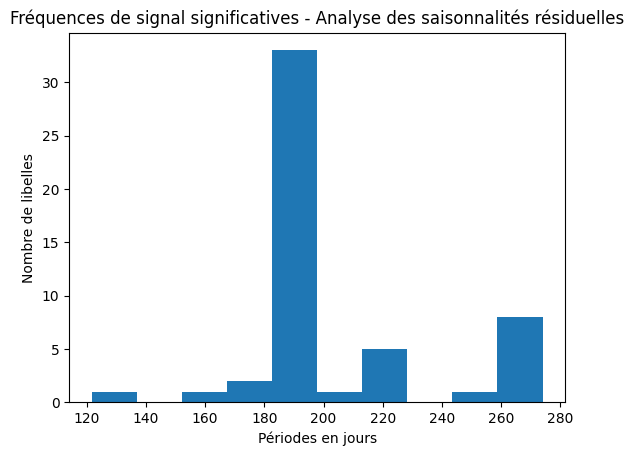

In [288]:
plt.hist(freqs_libelle['period'])
plt.xlabel('Périodes en jours')
plt.ylabel('Nombre de libelles')
plt.title('Fréquences de signal significatives - Analyse des saisonnalités résiduelles')
plt.show()

33 compteurs ont une saisonnalité semestrielle. Il n'existe pas d'autres périodes de saisonnalité significative dans nos données.

## Contingence des saisonnalités semestrielles et annuelles

Observons la table de contingence des saisonnalités trouvées

In [289]:
# Ajouter les colonnes binaires (>10% ou <=10%)
svr_series['annual_bin'] = (svr_series['svr_annual'] > 0.1).astype(int)
svr_series['semestrial_bin'] = (svr_series['svr_semestrial'] > 0.1).astype(int)

# Construire la table de contingence
contingency = pd.crosstab(
    index=svr_series['semestrial_bin'],  # lignes
    columns=svr_series['annual_bin']     # colonnes
)

# Renommer les lignes et colonnes pour plus de lisibilité
contingency.index = ['svr_semestrial <=10%', 'svr_semestrial >10%']
contingency.columns = ['svr_annual <=10%', 'svr_annual >10%']

print(contingency)

                      svr_annual <=10%  svr_annual >10%
svr_semestrial <=10%                41               84
svr_semestrial >10%                  0               58


142 (78% du total) des compteurs ont une saisonnalité annuelle significative.\
58 d'entre eux (31% du total) ont aussi une saisonnalité semestrielle significative.\
Le reste des compteurs (22% du total) ne possède pas de saisonnalité.

NB : nous trouvons ici 58 compteurs avec le SVR, au lieu de 33 avec la FFT. L'écart vient de la méthode FFT qui "dilue" les fréquences de grande période dans des harmoniques.

Nous allons vérifier le poids de chaque saisonnalité sur le groupe contenant les deux.


Exemple sans saisonnalité annuelle et sans saisonnalité semestrielle


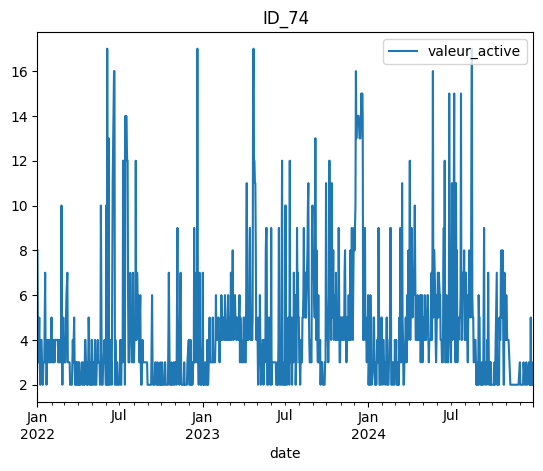


Exemple sans saisonnalité annuelle et avec saisonnalité semestrielle
  Aucun libelle correspondant à cette combinaison, skipping.

Exemple avec saisonnalité annuelle et sans saisonnalité semestrielle


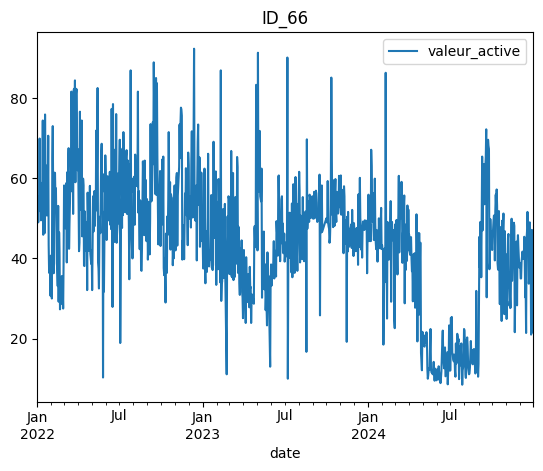


Exemple avec saisonnalité annuelle et avec saisonnalité semestrielle


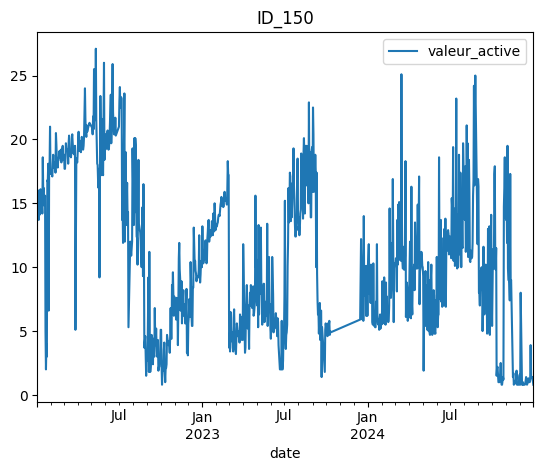

In [290]:
for a in range(2):
    for s in range(2):
        mask=(svr_series['svr_annual']>=a*0.1) & (svr_series['svr_semestrial']>=s*0.1) & (svr_series['annual_bin']==a) & (svr_series['semestrial_bin']==s)
        total_libelle=mask.sum()
        print()
        print(f"Exemple {'avec' if a else 'sans'} saisonnalité annuelle et {'avec' if s else 'sans'} saisonnalité semestrielle")
 
        if total_libelle==0:
            print("  Aucun libelle correspondant à cette combinaison, skipping.")
            continue

        random_libelle=(svr_series[mask]
                                .sample(1)
                                .index[0])

        (data_resampled[data_resampled["libelle"]==random_libelle]
                                .set_index('date')
                                .plot())
        plt.title(random_libelle)
        plt.show()

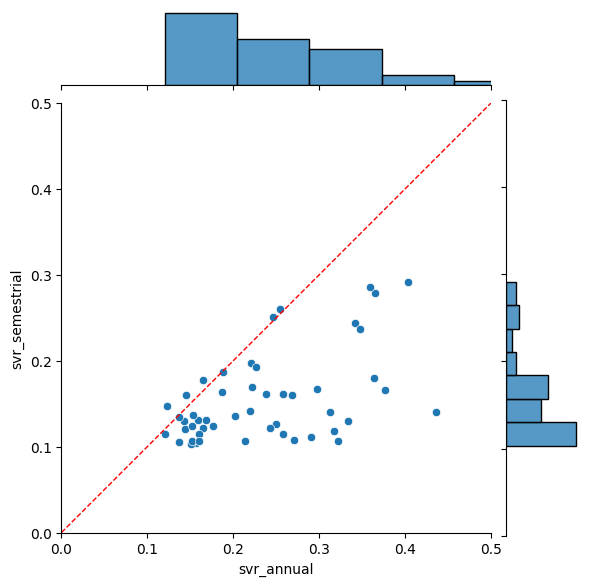

In [291]:
mask=(svr_series['annual_bin']==True) & (svr_series['semestrial_bin']==True)
g=sns.jointplot(data=svr_series[mask],x='svr_annual', y='svr_semestrial')

g.ax_joint.set_xlim(0, 0.5)
g.ax_joint.set_ylim(0, 0.5)
g.ax_joint.plot([0, 0.5], [0, 0.5], 'r--', lw=1)

# ratio 1:1
g.ax_joint.set_aspect('equal', adjustable='box')

Pour la plupart des compteurs, la saisonnalité annuelle est plus marquée que la saisonnalité semestrielle. D'autre part, la saisonnalité semestrielle amplifie la saionnalité annuelle qui ressort renforcée.

**Conclusion** : L’analyse met en évidence une saisonnalité annuelle statistiquement significative pour 78% des compteurs étudiés. Parmi ces derniers, plus d’un tiers présentent également une composante saisonnière semestrielle, dont l’intensité demeure toutefois inférieure à celle de la saisonnalité annuelle. Aucune autre fréquence saisonnière n’apparaît de manière significative sur l’ensemble du jeu de données. En conséquence, l'utilisation de la STL est exclue pour les raisons citées auparavant et du fait de la présence d'une seconde composante saisonnière.

# Détection de fuite

## Décomposition Residuel

In [292]:
def decompose(group, window=30):
    """
    Considérant Signal = Trend x Seasonnal x Bruit
    1/ Calcul d'un ratio de trend en comparant des fenetres de 6 mois d'une année sur l'autre
    2/ Calcul d'une prédiction sur la fenetre de prediction (window) à partir des valeurs de l'année précédente ajustée du trend
    3/ Calcul d'une prédiciton baseline à partir des valeurs de l'année précédente non ajustée du trend
    Retourne :
    - valeur_pred = valeur active en dehors de la fenetre de prediction, prediction sur la fenetre de prediction
    - valeur_pred_baseline = idem
    - trend
    - valeur_residual = valeur_active - valeur_pred
    - valeur_residual_baseline = valeur_active - valeur_pred_baseline
    """
    group = group.sort_values("date").copy()
    y = group["valeur_active"].to_numpy()
    t_full = np.arange(len(group))

    # -----------------------------
    # 1. calcul tendance
    # -----------------------------
    trend = y[-window-180:-window].mean()/y[-window-180-365:-window-365].mean()
        
    # ---------------------------------------
    # 2. calcul prediction
    # ---------------------------------------
    y_pred=y.copy()
    y_pred[-window:]=y_pred[-window-365:-365] * trend
        
    # ---------------------------------------
    # 3. calcul prediction baseline
    # ---------------------------------------
    y_pred_baseline = y.copy()
    y_pred_baseline[-window:]=y_pred_baseline[-window-365:-365]

    # ---------------------------------------
    # 4. return final 
    # ---------------------------------------
    group['trend']=trend
    group['valeur_pred'] = y_pred
    group['valeur_residual']=group['valeur_active']-group['valeur_pred']
    group['valeur_pred_baseline'] = y_pred_baseline
    group['valeur_residual_baseline']=group['valeur_active']-group['valeur_pred_baseline']
    
    return group


In [293]:
window=30
data_with_trend = data_resampled.groupby('libelle', group_keys=False).apply(decompose, window=window)

/tmp/ipykernel_5516/1373467318.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_with_trend = data_resampled.groupby('libelle', group_keys=False).apply(decompose, window=window)


Illustration

Text(0.5, 1.0, 'ID_129')

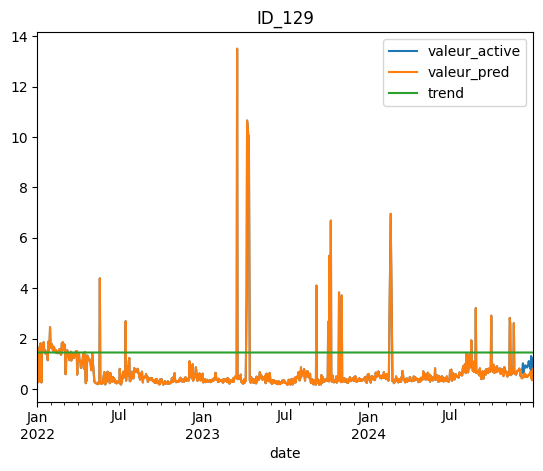

In [294]:
libelle='ID_129'
data_with_trend[data_with_trend['libelle']==libelle].set_index('date')[['valeur_active', 'valeur_pred', 'trend']].plot()
plt.title(libelle)

## Analyse du résiduel

In [295]:
def trend_score(group, window, colonne):
    """
    balance des énergies résiduelles positives et négatives = Indicateur de tendance borné dans [-1, 1]
    +1 : augmentation continue
     0 : série globalement constante
    -1 : diminution continue
    """
    group = group.sort_values("date")

    if len(group) < window:
        return np.nan

    serie = group[colonne].iloc[-window:].to_numpy()

    pos_energy = np.sum(np.clip(serie, 0, None) ** 2)
    neg_energy = np.sum(np.clip(-serie, 0, None) ** 2)

    total_energy = pos_energy + neg_energy

    if total_energy==0:
        return np.nan

    return (pos_energy - neg_energy) / total_energy

In [296]:
def level_score(group, window, colonne):
    """
    niveau moyen (absolu) du résiduel vs niveau moyen de consommation sur les 365 jours précédents (pour s'affranchir des saisonnalités et des tendances)
    """
    group = group.sort_values("date")

    if len(group) < window :
        return np.nan

    residual = group[colonne].iloc[-window:]
    total = group["valeur_active"].iloc[-window-365:-window-1]

    residual_energy = abs(residual.mean())
    total_energy = total.mean()

    return residual_energy / total_energy

In [297]:
metric_fuite = (
    data_with_trend
    .groupby("libelle")
    .apply(lambda g: pd.Series({
        "level_score": level_score(g, window=window, colonne='valeur_residual'),
        "trend_score": trend_score(g, window=window, colonne='valeur_residual'),
    }))
)

/tmp/ipykernel_5516/3094324711.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


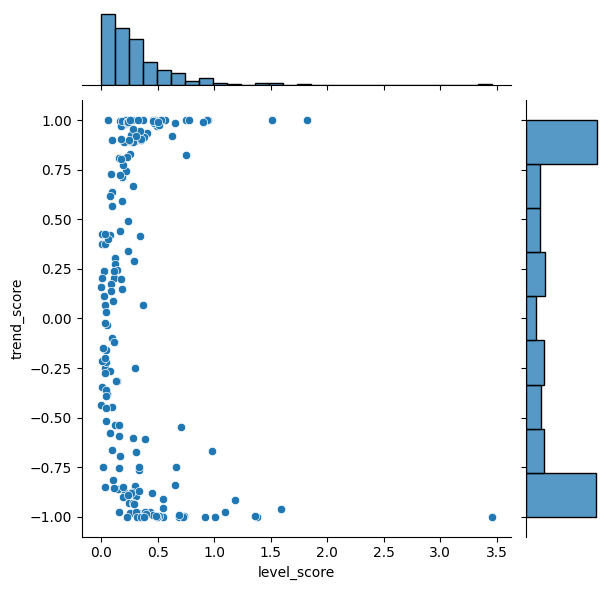

In [298]:
sns.jointplot(data=metric_fuite,x='level_score', y='trend_score')

In [299]:
fuites_principales=metric_fuite[(metric_fuite['trend_score']>0.9) & (metric_fuite['level_score']>0.7)].index

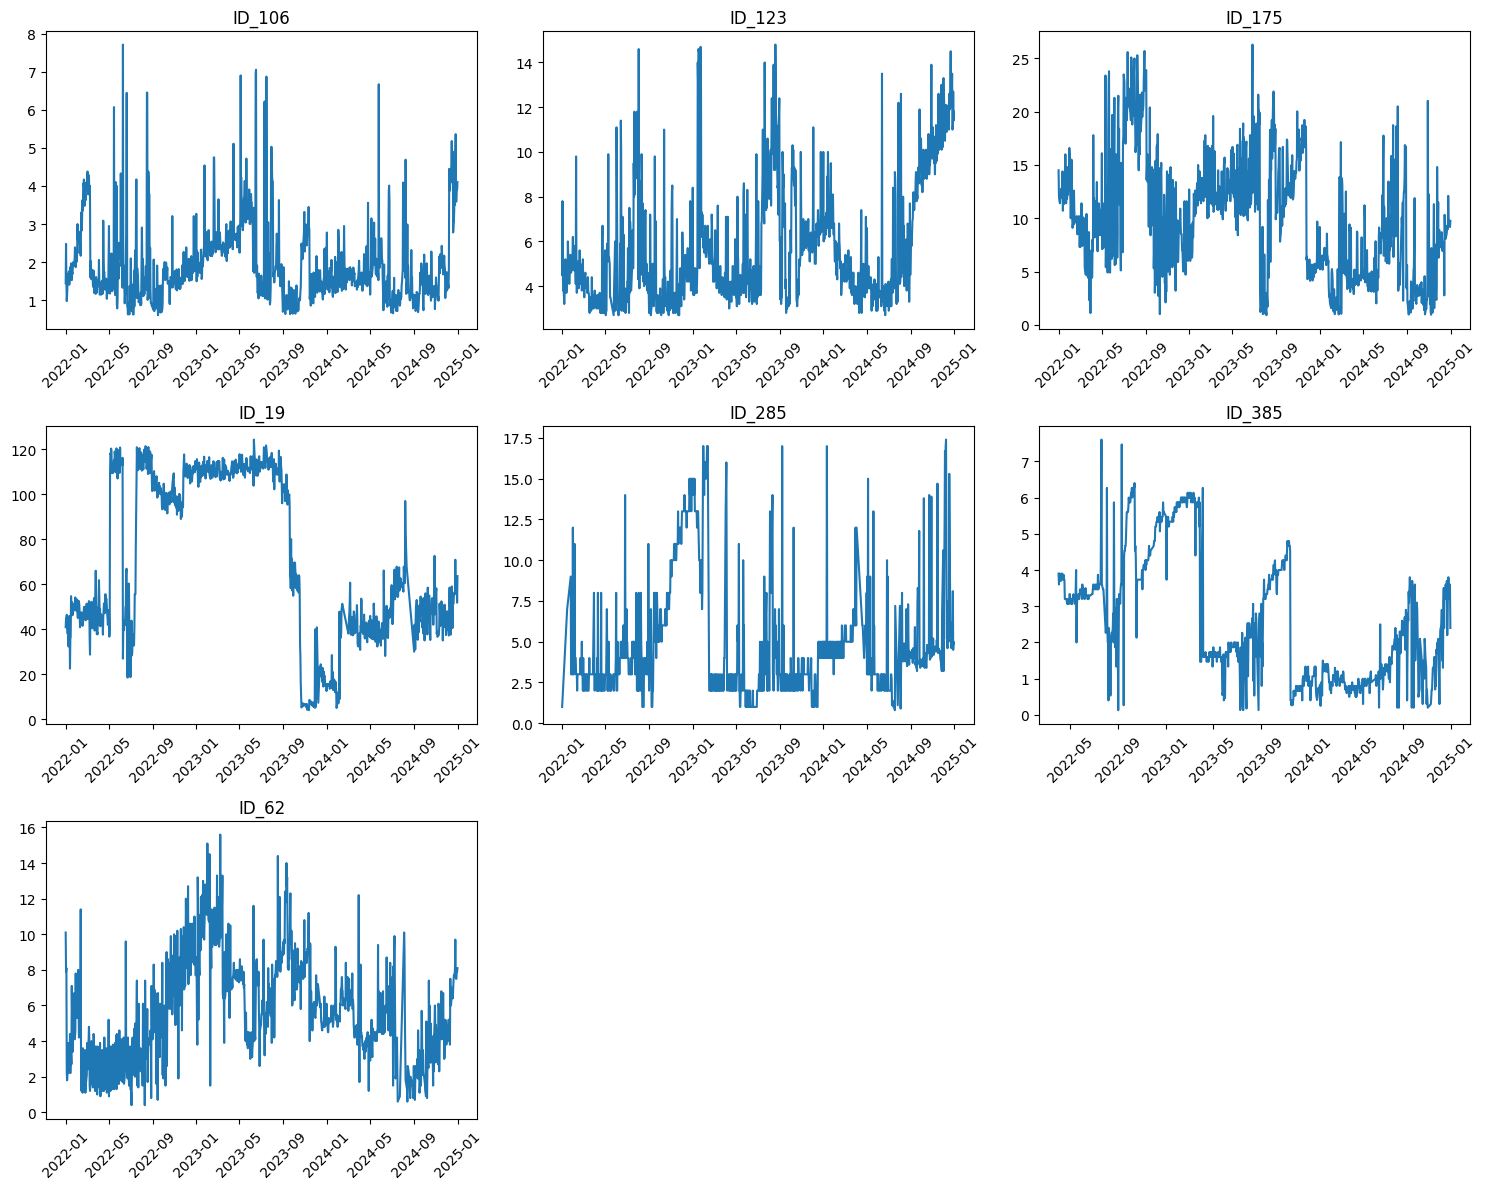

In [300]:
impression(data_with_trend, colonnes=['valeur_active'], libelles=fuites_principales)

## Comparaison Baseline

In [301]:
metric_fuite_baseline = (
    data_with_trend
    .groupby("libelle")
    .apply(lambda g: pd.Series({
        "level_score": level_score(g, window=window, colonne='valeur_residual_baseline'),
        "trend_score": trend_score(g, window=window, colonne='valeur_residual_baseline'),
    }))
)

/tmp/ipykernel_5516/930511533.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


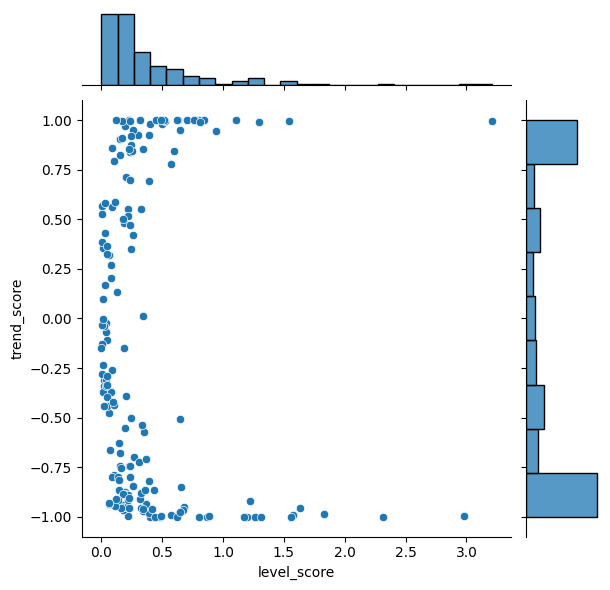

In [302]:
sns.jointplot(data=metric_fuite_baseline,x='level_score', y='trend_score')

In [303]:
fuites_principales_baseline=metric_fuite_baseline[(metric_fuite_baseline['trend_score']>0.9) & (metric_fuite_baseline['level_score']>0.8)].index

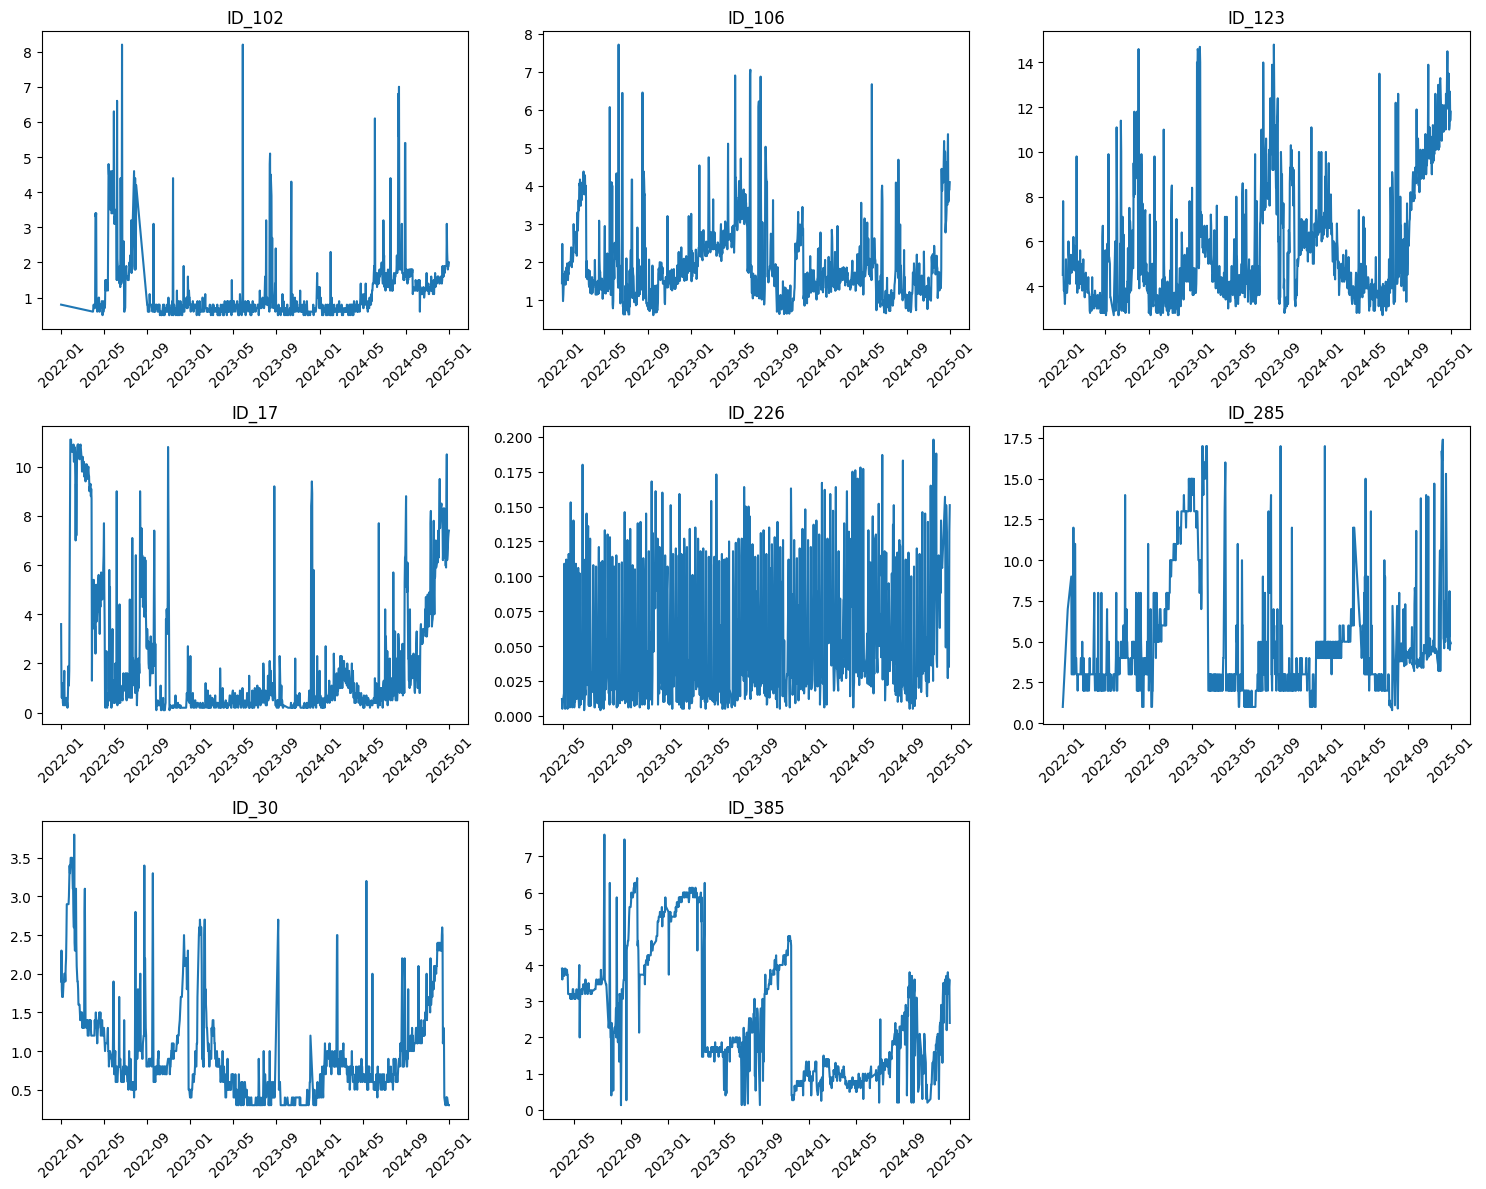

In [305]:
impression(data_with_trend, colonnes=['valeur_active'], libelles=fuites_principales_baseline)

## étude complémentaire trend

In [311]:
def shift(group, lag=365):
    """
    Calcule la différence annuelle x(t) - x(t - lag) pour une série temporelle.

    Parameters
    ----------
    group : pd.DataFrame
        Sous-dataframe correspondant à un libellé, contenant
        au minimum ['date', 'valeur_active']
    lag : int
        Décalage temporel (en jours), par défaut 365

    Returns
    -------
    pd.DataFrame
        DataFrame enrichi d'une colonne 'trend_shift'
    """
    group = group.sort_values("date").copy()

    group["trend_shift"] = (
        group["valeur_active"]
        / group["valeur_active"].shift(lag)
    )

    return group


In [312]:
data_with_shift = (
    data_resampled
    .groupby("libelle", group_keys=False)
    .apply(shift)
)


/tmp/ipykernel_5516/3060031550.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(shift)


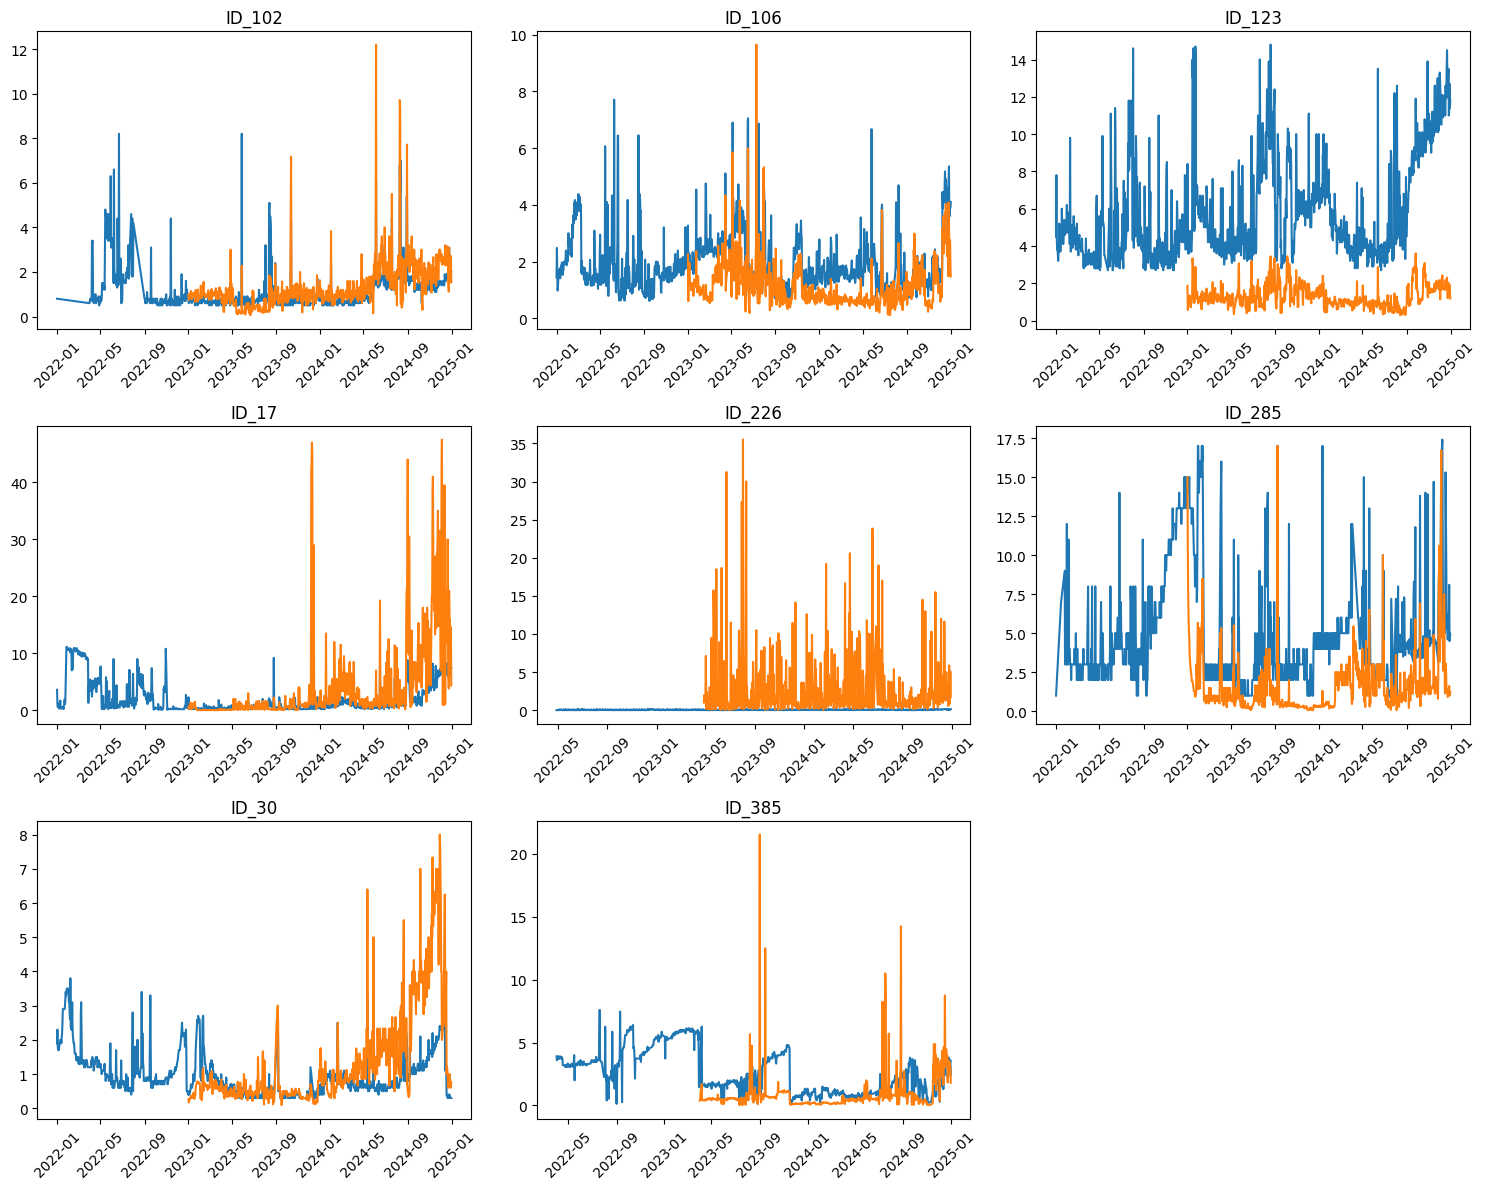

In [313]:
impression(data_with_shift, colonnes=['valeur_active', 'trend_shift'],libelles=fuites_principales_baseline)